# Machine Learning Model Analysis and Report

The following report aims to explain and analyze the performance of a machine learning model implementation; for this particular case, a Neural Network model was developed through the SciKit Learn libraries. The NN is intended for solving multilabel classification tasks. The neural network model was refined through training, validation and testing; at the same time, a gridsearch took place in order to tune the hyperparameters of the model and find the optimal options for the best performance.

For the whole training and testing process of the Neural Network, a Palmer Archipielago Penguin database was used; this dataset contains information that allows to solve a classification problem, which consists in determining the species of a penguin based on certain features; the features of the dataset include the island where the penguin is located, its culmen length and depth, its flipper length and depth, its body mass and sex.

The neural network requires, as input, certain parameters, such as its hidden layers size, activation function, solver, amongst others. In order to find the best model, a gridsearch with the possible hyperparameters took place with the training set. The metric that I was trying to optimize the search is the accuracy, so the model with the best accuracy score was chosen. Once the model was determined, validations were done in order to approve the model for predictions. Validation consisted in evaluating the chosen model with a rand new section of the dataset, while comparing the metrics obtained in both training and validation.

Once training and validation were done, several metrics were obtained in order to check if the model worked correctly when making predictions for each of the three possible outputs. These metrics and predictions were done on the third part of the dataset, which is the testing subset. First, a confusion matrix was computed, in order to contrast the prediction outcome with the real information of the penguin's species. Then, accuracy, precision, recall and the f1-score were obtained, in order to perform a complete analysis of the results and performance.

Later on, details will be given on the implementation and each particular task that was performed.

### Database Preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings("ignore")

In order to perform a successful classification task, the database must be transformed so that all variables are numeric and can be interpreted by the neural network. This encoding is also executed on the target variable, which ends up having 3 possible values. Neural network only receives numeric inputs, so different categories are created with a certain numeric value, according to the total amount of possible inputs for each feature.

In [2]:
df=pd.read_csv("penguins_size.csv")
df=df.dropna()
df=df[df['sex'] != "."]

X=df.drop("species",axis=1)
y=pd.DataFrame(df["species"])

from sklearn import preprocessing
le = preprocessing.LabelEncoder()

le.fit(X.island.unique().tolist())
X['island']=le.transform(X['island'])

le.fit(X.sex.unique().tolist())
X['sex']=le.transform(X['sex'])

le.fit(y.species.unique().tolist())
y=le.transform(y)
y=pd.DataFrame(y,columns=['species'])

Later on, for studying if the model tends to either overfit or underfit, the database must be separated into three different subsets, training, validation and testing. The  first one will be used for generating the neural network model, so that the model gets its main parameters. Afterwards, the validation model is used for studying if the model is actually performing well with data that was not part of training, and it can be used for comparing models and if they generalize appropriately. Finally, the testing subset is used as a brand-new sample, and allows to verify if the model can perform with new information and data.

The size of the three tests was chosen accordingly to the theory studied in class, where it was specified that in most cases, using 60% of the database for training, 20% for validation and the rest for trainig, works appropriately.

### Train-Test-Split

In [3]:
X_train,X_test,y_train,y_test=train_test_split(X,y,train_size=0.8,random_state=1)

train_ratio = 0.6
validation_ratio = 0.2
test_ratio = 0.2

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=1-train_ratio)
X_val, X_test, y_val, y_test = train_test_split(X_test,y_test,test_size=test_ratio/(test_ratio+validation_ratio)) 

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(199, 6)
(199, 1)
(67, 6)
(67, 1)
(67, 6)
(67, 1)


### Neural Network Model Without Optimization

At the beginning of the analysis, a quite simple MultiLayer Perceptron model is generated, just to establish a starting point. The model uses a quite simplistic architecture, and accuracy is measured in order to determine its performance. Most of the parameters are the ones that the SciKit Learn library determines by default, which may not work accurately with the information that we are giving to the model for training.

In [4]:
simple_model=MLPClassifier(hidden_layer_sizes=(6,1))

simple_model.fit(X_train,y_train)
print("Training score: ",simple_model.score(X_train,y_train))

Training score:  0.21105527638190955


As expected, the simple model does not perform well. The training accuracy score is quite low, as less than half of the predictions will be correct. In order to modify this erratic behavior, it is necessary to change and try different hyperparameter inputs, which may vary quite a lot when being tested. Therefore, we have to try as many possible combinations as possible.

### Gridsearch for Optimizing Hyperparameters

A gridsearch takes place, in order to determine which parameters work the best for the neural network model. The main objective of this search is to optimize the accuracy of predictions with the model. For the model generation, just the training subset is considered. The set of options that is evaluated in the gridsearch was chosen accordingly to the previous project (check https://github.com/alejandrodiazc/Machine_Learning_Framework_Use_for_the_Implementation_of_a_Solution for more information).

In [5]:
grid={"hidden_layer_sizes":[(6,2,2),(6,4,2),(6,2),(6,4),(6,1)],
    "activation":["relu","logistic"],
    "solver":["sgd","adam"],
    "learning_rate":["adaptive"],
    "learning_rate_init":[0.01,.05,0.1,0.5,1],
    "max_iter":[300],
    "random_state":[5]
}
model_gs=GridSearchCV(estimator=MLPClassifier(),param_grid=grid,refit=True,verbose=0,return_train_score=True)
model_gs.fit(X_train,y_train)

print("Best parameters: ",model_gs.best_params_)

Best parameters:  {'activation': 'relu', 'hidden_layer_sizes': (6, 4), 'learning_rate': 'adaptive', 'learning_rate_init': 0.05, 'max_iter': 300, 'random_state': 5, 'solver': 'adam'}


Once the best model is determined, it can be used for checking the accuracy metric with the validation subset. The main idea behind this is to notice if the created model can actually generalize well with information and data that was not employed during training. Similar results are expected for both training and validation accuracy, and indeed, it can be noticed that the performance is quite close.

In [6]:
best_model=MLPClassifier(hidden_layer_sizes=(6,4),activation='relu',solver='adam',learning_rate='adaptive',learning_rate_init=0.05,max_iter=300,random_state=5,verbose=False)

best_model.fit(X_train,y_train)
print("Training score: ",best_model.score(X_train,y_train))
print("Validation score: ",best_model.score(X_val,y_val))

Training score:  0.7085427135678392
Validation score:  0.7313432835820896


Even though the scores for both training and validation aren't optimal, they actually work fine for a simple model. It can be determined that there is no overfitting in the model, since the score for training is not high enough or perfect; at the same time, there isn't a low accuracy score for the validation set, which means that the model can actually generalize pretty well and on a similar level to the one the training has. 

On the other hand, determining underfitting can be trickier, since the score values for both training and testing aren't really high, but they are quite far away from the optimal ones. Since the accuracy values are in the range of .6 and.75, the model can be considered a bit underfitted, because there is a relatively high error while modelling and also the neural network does not perform as well as it should when generalizing for new information.

### Learning Curve

In order to evaluate how the model generalizes new information and to understand deeply if there is underfitting or overfitting, a learning curves analysis is performed. The main objective of this graph is to detect if there is a significant change in the error that the model presents, if it is trained with a different amount of samples. Learning curves allow to understand how the accuracy or some other metric evolves within bot the training and validation set.

While studying the penguin species database, it was decided to implement a learning curve that evaluated the whole database, since the SciKit Learn library employs cross-validation for separating the database and for studying its behavior with different sample sizes.

The resulting graph shows that, at the beginning, the accuracy of the model is quite perfect if the sample size is small; once it reaches a considerable size, overfitting stops and a more realistic model is generated. At the same time, the exact opposite happens with the validation set; at first, with a small sample size the accuracy score is quite low, and while the sample gets bigger, the score tends to go higher. When the training sample size is close to 220 instances, both lines tend to converge close one to the other. This behavior shows that there is no overfitting within the model, but it has certain tendency to underfit the data, as the accuracy score is still low.

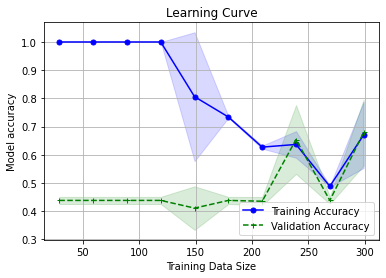

In [7]:
# Use learning curve to get training and validation scores along with train sizes

train_sizes, train_scores, val_scores = learning_curve(estimator=best_model,X=X,y=y,cv=10,train_sizes=np.linspace(0.1, 1.0, 10))

# Calculate training and validation mean and std

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Plot the learning curve

plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training Accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, val_mean, color='green', marker='+', markersize=5, linestyle='--', label='Validation Accuracy')
plt.fill_between(train_sizes, val_mean + val_std, val_mean - val_std, alpha=0.15, color='green')
plt.title('Learning Curve')
plt.xlabel('Training Data Size')
plt.ylabel('Model accuracy')
plt.grid()
plt.legend(loc='lower right')
plt.show()

### Validation, Testing and Performance Evaluation

Once the training has finished and we determined the training size was adequate, a confusion matrix can be computed in order to evaluate how well the model performs when making predictions. For doing so, first some predictions had to be done while evaluating the data from the validation set with the neural network. Since the possible output consists of three different labels, the confusion matrix is formed by three rows and three columns.

In the resulting matrix, the predictions actually show that the model performs quite well when determining the Adelie and Gentoo species; however, it must be noted that when working with the validation set, the neural network never gave an output of the Chinstrap species, which could be explained by the possible underfitting of the model.

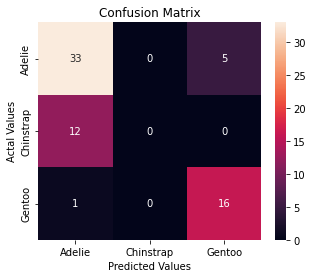

In [8]:
y_pred_val=best_model.predict(X_val)

cm_val=confusion_matrix(y_val,y_pred_val)
cm_val_df = pd.DataFrame(cm_val,index=['Adelie','Chinstrap','Gentoo'],columns=['Adelie','Chinstrap','Gentoo'])

#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_val_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

For further study regarding the results of the confusion matrix, 4 different metrics can be computed, These metrics consider the true positives, false positives, true negatives and false negatives for each of the possible outcomes.

Regarding each one of the metrics:

- Accuracy: metric that tries to show how well the model works when determining if an instance belongs to a class or not.
- Precision: aims to determine how the model performs when detecting a positive class.
- Recall: ratio of positive instances that were detected correctly.
- F1 score: combines precision and recall into one metric.

In [9]:
tp_a_val=cm_val[0][0]
tp_c_val=cm_val[1][1]
tp_g_val=cm_val[2][2]
fn_a_val=cm_val[0][1]+cm_val[0][2]
fn_c_val=cm_val[1][0]+cm_val[1][2]
fn_g_val=cm_val[2][0]+cm_val[2][1]
fp_a_val=cm_val[1][0]+cm_val[2][0]
fp_c_val=cm_val[0][1]+cm_val[2][1]
fp_g_val=cm_val[0][2]+cm_val[1][2]
tn_a_val=cm_val[1][1]+cm_val[1][2]+cm_val[2][1]+cm_val[2][2]
tn_c_val=cm_val[0][0]+cm_val[0][2]+cm_val[2][0]+cm_val[2][2]
tn_g_val=cm_val[0][0]+cm_val[0][1]+cm_val[1][0]+cm_val[1][1]

In [10]:
acc_a_val=(tp_a_val+tn_a_val)/(tp_a_val+tn_a_val+fp_a_val+fn_a_val)
print("Accuracy for Adelie:",acc_a_val)
pre_a_val=tp_a_val/(tp_a_val+fp_a_val)
print("Precision for Adelie:",pre_a_val)
rec_a_val=tp_a_val/(tp_a_val+fn_a_val)
print("Recall for Adelie:",rec_a_val)
f1_a_val=2*pre_a_val*rec_a_val/(pre_a_val+rec_a_val)
print("F1-score for Adelie:",f1_a_val)
acc_c_val=(tp_c_val+tn_c_val)/(tp_c_val+tn_c_val+fp_c_val+fn_c_val)
print("Accuracy for Chinstrap:",acc_c_val)
pre_c_val=tp_c_val/(tp_c_val+fp_c_val)
print("Precision for Chinstrap:",pre_c_val)
rec_c_val=tp_c_val/(tp_c_val+fn_c_val)
print("Recall for Chinstrap:",rec_c_val)
f1_c_val=2*pre_c_val*rec_c_val/(pre_c_val+rec_c_val)
print("F1-score for Chinstrap:",f1_c_val)
acc_g_val=(tp_g_val+tn_g_val)/(tp_g_val+tn_g_val+fp_g_val+fn_g_val)
print("Accuracy for Gentoo:",acc_g_val)
pre_g_val=tp_g_val/(tp_g_val+fp_g_val)
print("Precision for Gentoo:",pre_g_val)
rec_g_val=tp_g_val/(tp_g_val+fn_g_val)
print("Recall for Gentoo:",rec_g_val)
f1_g_val=2*pre_g_val*rec_g_val/(pre_g_val+rec_g_val)
print("F1-score for Gentoo:",f1_g_val)

Accuracy for Adelie: 0.7313432835820896
Precision for Adelie: 0.717391304347826
Recall for Adelie: 0.868421052631579
F1-score for Adelie: 0.7857142857142858
Accuracy for Chinstrap: 0.8208955223880597
Precision for Chinstrap: nan
Recall for Chinstrap: 0.0
F1-score for Chinstrap: nan
Accuracy for Gentoo: 0.9104477611940298
Precision for Gentoo: 0.7619047619047619
Recall for Gentoo: 0.9411764705882353
F1-score for Gentoo: 0.8421052631578947


Within the validation set, most of the metrics for both Adelie and Gentoo are within an acceptable range; however, Chinstrap predictions are quite weak, since there were no predictions for this class. This means that 3 out of 4 metrics are zero. The reason behind why the model behaves this way could be explained in the fact that there is some underfitting in it, as probably most of the information of the Chinstrap class is quite similar to the one of Adelie, causing that most of the predictions that actually belong to the former one go to the later one.

For further testing and analysis, the same methodology for obtaining metrics is performed with the testing subset.

Validation score:  1.0


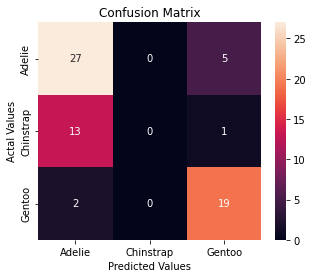

In [14]:
y_pred=best_model.predict(X_test)
print("Validation score: ",best_model.score(X_test,y_pred))

cm=confusion_matrix(y_test,y_pred)
cm_df = pd.DataFrame(cm,index=['Adelie','Chinstrap','Gentoo'],columns=['Adelie','Chinstrap','Gentoo'])

#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [12]:
tp_a=cm[0][0]
tp_c=cm[1][1]
tp_g=cm[2][2]
fn_a=cm[0][1]+cm[0][2]
fn_c=cm[1][0]+cm[1][2]
fn_g=cm[2][0]+cm[2][1]
fp_a=cm[1][0]+cm[2][0]
fp_c=cm[0][1]+cm[2][1]
fp_g=cm[0][2]+cm[1][2]
tn_a=cm[1][1]+cm[1][2]+cm[2][1]+cm[2][2]
tn_c=cm[0][0]+cm[0][2]+cm[2][0]+cm[2][2]
tn_g=cm[0][0]+cm[0][1]+cm[1][0]+cm[1][1]

In [13]:
acc_a=(tp_a+tn_a)/(tp_a+tn_a+fp_a+fn_a)
print("Accuracy for Adelie:",acc_a)
pre_a=tp_a/(tp_a+fp_a)
print("Precision for Adelie:",pre_a)
rec_a=tp_a/(tp_a+fn_a)
print("Recall for Adelie:",rec_a)
f1_a=2*pre_a*rec_a/(pre_a+rec_a)
print("F1-score for Adelie:",f1_a)
acc_c=(tp_c+tn_c)/(tp_c+tn_c+fp_c+fn_c)
print("Accuracy for Chinstrap:",acc_c)
pre_c=tp_c/(tp_c+fp_c)
print("Precision for Chinstrap:",pre_c)
rec_c=tp_c/(tp_c+fn_c)
print("Recall for Chinstrap:",rec_c)
f1_c=2*pre_c*rec_c/(pre_c+rec_c)
print("F1-score for Chinstrap:",f1_c)
acc_g=(tp_g+tn_g)/(tp_g+tn_g+fp_g+fn_g)
print("Accuracy for Gentoo:",acc_g)
pre_g=tp_g/(tp_g+fp_g)
print("Precision for Gentoo:",pre_g)
rec_g=tp_g/(tp_g+fn_g)
print("Recall for Gentoo:",rec_g)
f1_g=2*pre_g*rec_g/(pre_g+rec_g)
print("F1-score for Gentoo:",f1_g)

Accuracy for Adelie: 0.7014925373134329
Precision for Adelie: 0.6428571428571429
Recall for Adelie: 0.84375
F1-score for Adelie: 0.7297297297297298
Accuracy for Chinstrap: 0.7910447761194029
Precision for Chinstrap: nan
Recall for Chinstrap: 0.0
F1-score for Chinstrap: nan
Accuracy for Gentoo: 0.8805970149253731
Precision for Gentoo: 0.76
Recall for Gentoo: 0.9047619047619048
F1-score for Gentoo: 0.8260869565217391


After trying out the model with the testing set, it can be confirmed that the model tends to behave in a similar way with all of the data it is presented. Metrics and the confusion matrix also confirm that predictions for both Adelie and Gentoo work fine, since there tends to be a certain generalization in the obtained results and performance. Simultaneously, when working with the Chinstrap label, the fact that there were no predictions towards it continues, which means that the model lacks enough information in order to decide that a penguin with certain characteristics belongs to this specific class.

Once the whole stody was performed and the metrics were obtained, it can be determined that even after optimizing the parameters and training/testing sizes for the neural network, there exists a certain level of underfitting, since the model fails to explain correctly when an instance belongs to the Chinstrap species. A possible solution for this would be extending the database with information from this particular class; providing more details should work for making more accurate predictions without falling into an overfitting of the model. Another option could be to generate a more complex model, which allows to adjust the predictions for that particular class; nevertheless, the gridsearch that was performed at the beginning of the analysis actually considered some neural network models which were a bit more complex, adding hidden layers and nodes to the model. This could possibly mean that a neural network is not the best option for performing a classification task with this particular database, ando some additional model could work better.

### Bias and Variance

Once all of the metrics were computed for testing, training and validation, we can continue with the analysis and their overall meaning in terms of the model adjustment.

Firstly, it must be considered that all of training, validation and testing actually generalized quite well, as their metrics behaved in a similar way and they do not vary a lot. This means that the model generalizes correctly and therefore, overfitting does not occur. An overfitted model would perform almost perfectly in trainig, but when checking out new data (such as the validation and testing models), its predictions would differ quite a lot and there would be a great error. Since the neural network model does not vary a lot when computing metrics for each phase of generation, then overfitting is discarded.

Afterwards, it has to be noted that the predictions always discarded or even avoided one of the possible outputs for the target variable (one of the penguin species). This is appreciated within the metrics for validation and testing, since they remain a bit far away from optimal values. Since the model fails to predict adequately the target valuable for one of the instances (and there is also some error when discerning between the other two possible outputs), there appears to be some underfitting. The underfitting of the model can be understood since there is a relatively high bias when classifying the instances; there is always some error. Even though the variance level is medium (the testing, training and validation data behaves quite similarly when being used by the model), the model lacks some complexness for generating more accurate and precise predictions.

In order to optimize the model, probably more information regarding the Chinstrap species is needed; adding more instances of that particular specied may lead the model to know better when to predict it as the output of a certain instance. At the same time, it must be mentioned that probably a neural network implemented through the SciKit Learn is not the best working model for this classification task. I could arrive to this conclusion because at the beginning, the first model had quite a high bias (predictions were mostly inaccurate); then, when searching for a better model with different hyperparameters, the model worked better; however, it still lacked better results for actually being useful for the classification task. A more complex neural network approach (which cannot be generated through SciKit Learn) may work better and lead to results with an acceptable bias and variance.